# Problem Set 5, due Nov 5 at 11:59pm

As usual, you are highly encouraged to *start this problem set early!*  My best guess (no guarantees!) is that Part 1 will be conceptually easy but perhaps time consuming.  Parts 2 and 3 are medium difficult, but there are plenty of opportunities to get confused with python data structures, so if you're going to get stuck, get stuck (and unstuck) early!

Note that the two extra credit problems have the potential to be quite challenging and time consuming. Make sure to do everything else in the problem set before you tackle the extra credit.

To get started, download the files "reviews.csv" and "movies.dat" from Canvas.

For this assignment, the following libraries may be useful:

* [numpy](http://docs.scipy.org/doc/numpy-dev/user/index.html), for arrays
* [scikit-learn](http://scikit-learn.org/stable/), for machine learning
* [pandas](http://pandas.pydata.org/), for data frames
* [matplotlib](http://matplotlib.org/), for plotting

In particular, I suggest you familiarize yourself with the following aspects of these libraries, which are not required but which might make your life easier:

* `DataFrame` and other basic [data structures](http://pandas.pydata.org/pandas-docs/stable/dsintro.html) in pandas
* [`groupby`](http://pandas.pydata.org/pandas-docs/stable/groupby.html), `unique`,  and other simple aggregation functions
* [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) for working with text in sklearn.
* [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) for Naive Bayes
* Simple tools for [Cross-Validation](http://scikit-learn.org/stable/modules/cross_validation.html) in sklearn

Make sure they load properly with the following code block:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#hint: Consult the scikit-learn documentation to
#      learn about what these classes do do
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Introduction to the assignment

In this assignment, you'll be analyzing movie reviews in an attempt to determine whether movies are good or bad.  I've downloaded a large number of movie reviews from the [Rotten Tomatoes](http://www.rottentomatoes.com) website, which are available in the file "reviews.csv" on Canvas.  I've also put a file "movies.dat" on Canvas that contains metadata for ~65,000 different movies

If you've never seen Rotten Tomatoes before, go spend a few minutes familiarizing yourself with the website.  It's a meta-review website that aggregates movie reviews from a large number of critics.  Here's what the page for this year's [Oscar winner](https://www.rottentomatoes.com/m/the_shape_of_water_2017) looks like.  Note in particular the section on "Critic Reviews" at the bottom -- that's the content that has been scraped and put in the reviews.csv file.  Also note that each movie is given a quantitative score on the Tomatometer which is used to classify the movie as either Fresh (good) or Rotten (bad).

Your mission is to develop a classifier to determine whether a movie is Fresh or Rotten based on the contents of the reviews given to the movie.  As usual, we'll start out with some exploratory data analysis.

---

## Part 1: Descriptive analysis

Before beginning the "real" work, dig into the data a bit do see what you're dealing with.  Begin by loading the datasets and dropping rows that have missing data:

In [2]:
reviews = pd.read_csv('reviews.csv')
movies = pd.read_csv('movies.dat', delimiter='\t')

# just check the quote and fresh columns
reviews = reviews[~reviews['quote'].isnull()]
reviews = reviews[reviews['fresh'] != 'none']
reviews = reviews[reviews['quote'].str.len() > 0]
reviews.reset_index(drop=True, inplace=True)

# just check the year and rtAllCriticsRating columns
movies = movies[~movies['rtAllCriticsRating'].isnull()]
movies = movies[movies['rtAllCriticsRating']!='\\N']
movies['rtAllCriticsRating'] = movies['rtAllCriticsRating'].astype(float)
movies = movies[movies['rtAllCriticsRating']!=0]
movies = movies[~movies['year'].isnull()]
movies.reset_index(drop=True, inplace=True)

In [3]:
reviews.columns

Index(['critic', 'fresh', 'imdb', 'link', 'publication', 'quote',
       'review_date', 'rtid', 'title'],
      dtype='object')

In [4]:
movies.columns

Index(['id', 'title', 'imdbID', 'spanishTitle', 'imdbPictureURL', 'year',
       'rtID', 'rtAllCriticsRating', 'rtAllCriticsNumReviews',
       'rtAllCriticsNumFresh', 'rtAllCriticsNumRotten', 'rtAllCriticsScore',
       'rtTopCriticsRating', 'rtTopCriticsNumReviews', 'rtTopCriticsNumFresh',
       'rtTopCriticsNumRotten', 'rtTopCriticsScore', 'rtAudienceRating',
       'rtAudienceNumRatings', 'rtAudienceScore', 'rtPictureURL'],
      dtype='object')

### 1.1: Basic features of the dataset

Answer the following questions by having your python code directly print the answers:

* How many unique reviews (quotes) are in the `reviews` dataset?
* How many unique reviewers (critics) are in the `reviews` dataset?
* How many unique movies are in the `reviews` dataset?
* How many unique movies are in the *`movies`* dataset?
* How many different publications have reviews in the `reviews` dataset?


In [5]:
print('Number of unique reviews   = {}'.format(len(reviews['quote'].unique())))
print('Number of unique reviewers = {}'.format(len(reviews['critic'].unique())))

Number of unique reviews   = 12814
Number of unique reviewers = 541


In [6]:
print('Number of unique movies in the reviews dataset = {}'.format(len(reviews['title'].unique())))
print('Number of unique movies in the movies  dataset = {}'.format(len(movies['title'].unique())))

Number of unique movies in the reviews dataset = 1720
Number of unique movies in the movies  dataset = 7742


In [7]:
print('Number of unique publications in the reviews dataset = {}'.format(len(reviews['publication'].unique())))

Number of unique publications in the reviews dataset = 64


### 1.2 Number of reviews per reviewer

Using the `reviews` dataset, create a histogram showing the distribution of the number of reviews per reviewer.  Create the bin width (x-axis) to be 1 unit wide, and the range of the axis to be from 0 to 30.  Scale the y-axis to show the logarithm of (count of) the number of reviewers.  Label your axes and make your histogram look professional.

> <font color='red'>Note that I set the x-axis scale to be from 0-30, as is asked in the prompt.</font>

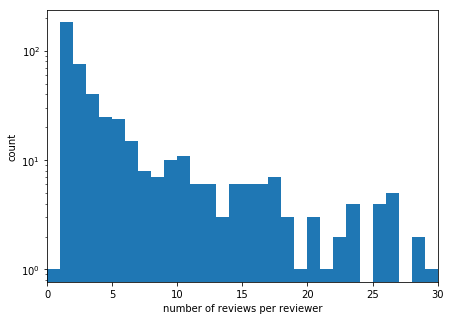

In [8]:
# get the unique reviewers
unique_reviewers = reviews['critic'].unique()

# get the number of reviews per unique reviewer
unique_reviewers_n = np.zeros(len(unique_reviewers))
for i in range(len(unique_reviewers)):
    n = len(reviews[reviews['critic']==unique_reviewers[i]])
    unique_reviewers_n[i] = n
    
# plot
fig, ax = plt.subplots(figsize=(7,5))

bins = np.arange(0,np.max(unique_reviewers_n)+1)
ax.hist(unique_reviewers_n, bins=bins, log=True)

ax.set_xlim(0,30)
ax.set_xlabel('number of reviews per reviewer')
ax.set_ylabel('count')

plt.show(fig)

### 1.3 Zoom in on a few reviewers
Find the 30 critics with the most reviews, and list their names in a table along with (a) the name of the publication they work for, (b) the date of their first review, and (c) the date of their last review

*hint: use the groupby function to do this quickly*

> <font color='red'>Sorry I was working on this without internet so I was not sure how to use the `groupby` function properly.</font>

In [9]:
# sort the arrays and pull out the highest 30
sort_inds = np.argsort(unique_reviewers_n)
unique_reviewers_most = unique_reviewers[sort_inds][-30:]
unique_reviewers_n_most = unique_reviewers_n[sort_inds][-30:]

# get the other information
publications_most = []
first_most = []
last_most = []
for i in range(len(unique_reviewers_most)):
    this_critic = reviews[reviews['critic']==unique_reviewers_most[i]]
    publications_most.append(this_critic['publication'].unique()[0])
    first_most.append(np.min(this_critic['review_date']))
    last_most.append(np.max(this_critic['review_date']))
    
# create dataframe
most_reviews = pd.DataFrame({'critic':unique_reviewers_most,
                             'n':unique_reviewers_n_most,
                             'publication':publications_most,
                             'first review date':first_most,
                             'last review date':last_most})
most_reviews

,critic,n,publication,first review date,last review date
0,Michael Wilmington,103.0,Chicago Tribune,2000-01-01 00:00:00,2013-11-21 00:00:00
1,Richard Corliss,104.0,TIME Magazine,2003-12-16 00:00:00,2013-11-06 00:00:00
2,Richard Schickel,106.0,TIME Magazine,2000-01-01 00:00:00,2013-08-05 00:00:00
3,Emanuel Levy,110.0,Variety,2000-01-01 00:00:00,2010-08-06 00:00:00
4,Liam Lacey,111.0,Globe and Mail,2001-08-24 00:00:00,2012-04-04 00:00:00
5,Lisa Schwarzbaum,117.0,Entertainment Weekly,1979-01-01 00:00:00,2012-08-15 00:00:00
6,Edward Guthmann,121.0,San Francisco Chronicle,2000-01-01 00:00:00,2003-04-04 00:00:00
7,Rick Groen,129.0,Globe and Mail,2002-03-19 00:00:00,2009-08-14 00:00:00
8,Bosley Crowther,137.0,New York Times,2000-01-01 00:00:00,2008-05-06 00:00:00
9,Peter Stack,138.0,San Francisco Chronicle,2000-01-01 00:00:00,2002-06-18 00:00:00


### 1.4 Ratings over time

Using the `movies` dataset, create a plot that shows how the average rating per movie (rtAllCriticsRating) has evolved over time.  Do this by creating a scatterplot where the x-axis is the year in which the movie was released and the y-axis is rtAllCriticsRating.  Drop movies with 0 or unknown values to avoid biasing your results.  Then, create a scatterplot that has one <year,rating> point for each remaining movie, and pick an appropriate size/color/transparency for these points to ensure that the graph looks professional.  In other words, do not simply use the default settings, as this will produce a dense mess of dots that will be hard to interpret.  Finally, overlay on this scatterplot a line graph in orange showing how the average movie rating (the average of rtAllCriticsRating across all movies in a year) has changed over time.  Do you notice a trend?  What do you think it means?

> <font color='red'>The movies dataframe was already cleaned up above.</font>

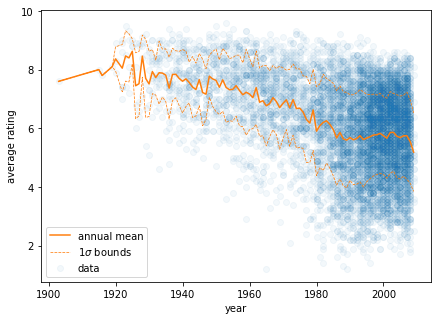

In [10]:
# get the unique years and sort
movies_years = movies['year'].unique()
movies_years = np.sort(movies_years)

# get the mean and standard deviation for each of the years
movies_years_means = np.zeros(len(movies_years))
movies_years_stds = np.zeros(len(movies_years))
for i in range(len(movies_years)):
    avg = np.mean(movies[movies['year']==movies_years[i]]['rtAllCriticsRating'])
    std = np.std(movies[movies['year']==movies_years[i]]['rtAllCriticsRating'])
    movies_years_means[i] = avg
    movies_years_stds[i] = std

# plot
fig, ax = plt.subplots(figsize=(7,5))

ax.scatter(movies['year'], movies['rtAllCriticsRating'], alpha=0.05, c='C0', label='data')
ax.plot(movies_years, movies_years_means, c='C1', label='annual mean')
ax.plot(movies_years, movies_years_means+movies_years_stds, c='C1', ls='--', lw=0.75, label='1$\sigma$ bounds')
ax.plot(movies_years, movies_years_means-movies_years_stds, c='C1', ls='--', lw=0.75, label='__nolegend')
ax.legend()
ax.set_xlabel('year')
ax.set_ylabel('average rating')

plt.show(fig)

> <font color='red'>As we can see from the plot above, as we move forward in time, we get more movies, decreasing annual mean ratings, and increasing standard deviations on the annual mean ratings. There are several possible explanations for these observed trends. First, it is possible that the barriers to making movies have become smaller with time (for instance through making technology better and cheaper), and thus more and generally less talented people were able to make movies as time progressed. Second, it is possible that the standard for a 'good movie' has increased with time, with an increase in the available number of movies that people can refer to as benchmarks. Third, it is possible that people have gotten meaner with time.</font>

---

## Part 2: Naive Bayes

Now it gets fun!  You are going to use a [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) to build a prediction model for whether a review is fresh or rotten, depending on the text of the review. Review the assigned readings on Canvas, as well as the relevant lecture notes before embarking on this journey.

### Using CountVectorizer

One thing that may help you in the following problems is the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) object in Scikit-learn.  This will help you convert your raw text fields into "bag of words" vectors, i.e. a data structure that tells you how many times a particular word appears in a blurb.  Here's a simple example, make sure you understand what's going on!

In [11]:
text = ['machine learning rocks', 'machine learning rules', 'rocks rocks rules']
print("Original text is\n", '\n'.join(text))
print()
vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("Transformed text vector is \n", x)
print()
# `get_feature_names` tracks which word is associated with each column of the transformed x
print("Words for each feature:")
print(vectorizer.get_feature_names())

Original text is
 machine learning rocks
machine learning rules
rocks rocks rules

Transformed text vector is 
 [[1 1 1 0]
 [1 1 0 1]
 [0 0 2 1]]

Words for each feature:
['learning', 'machine', 'rocks', 'rules']


### 2.1 Create your X input and Y output

Using the `reviews` dataframe, compute a pair of numerical X, Y arrays where:
    
 * X is a `(nreview, nwords)` array. Each row corresponds to a bag-of-words representation for a single review. This will be the *input* to your model.
 * Y is a `nreview`-element 1/0 array, encoding whether a review is Fresh (1) or Rotten (0). This is the desired *output* from your model.
 
Make sure to remove items with no review text

> <font color='red'>The reviews dataframe was already cleaned up above.</font>

In [12]:
def make_xy(reviews, vectorizer=None):
    """
    Build a bag-of-words training set for the review data.

    Parameters
    -----------
    reviews : Pandas DataFrame
        The review data from above

    vectorizer : CountVectorizer object
        A CountVectorizer object to use. If None,
        then create and fit a new CountVectorizer.
        Otherwise, re-fit the provided CountVectorizer
        using the reviews data

    Returns
    -------
    X : numpy array (dims: nreview, nwords)
        Bag-of-words representation for each review.
    Y : numpy array (dims: nreview)
        1/0 array. 1 = fresh review, 0 = rotten review

    Examples
    --------
    X, Y = make_xy(reviews)
    """
    # get Y
    Y = np.zeros(len(reviews.index))
    Y[reviews['fresh']=='fresh'] = 1
    
    # first, get quotes
    quotes = reviews['quote']
    
    # initialize the vectorizer if we need to
    if vectorizer == None:
        vectorizer = CountVectorizer(min_df=0)
        
    # fit
    vectorizer.fit(quotes)
    
    # convert text to a bag of words
    X = vectorizer.transform(quotes)

    # convert back to a "normal" numpy array
    X = X.toarray()
    
    return X, Y

> <font color='red'>Test the function:</font>

In [13]:
X, Y = make_xy(reviews)
print(np.shape(X))
print(np.shape(Y))

(13419, 20875)
(13419,)


### 2.2 Test-Train split

Next, randomly split the data into two groups: a training set (80%) and a validation set (20%).  You can do this manually, as you did in the prior problem set.  Or, use [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) to do this auto-magically.  See [this guide](http://scikit-learn.org/stable/modules/cross_validation.html) for a simple example of how `train_test_split` works.

In [14]:
train, test = train_test_split(reviews, test_size=0.2, random_state=22)

### 2.3 Naive Bayes with `MultinomialNB`
Use the training set to train a Naive Bayes classifier using the [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)
 object.  Report the accuracy of this model on both the training and testing data.  What do you observe?  Interpret these results!

*Hint: This shouldn't take more than 5-10 lines of code to accomplish*



> <font color='red'>A function to compute the accuracy:</font>

In [15]:
def compute_accuracy(predictions, yvalues):
    """
    Compute the accuracy given predictions and observations.
    """
    TP = sum((predictions==1) & (yvalues==1))
    TN = sum((predictions==0) & (yvalues==0))
    FP = sum((predictions==1) & (yvalues==0))
    FN = sum((predictions==0) & (yvalues==1))
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    return accuracy

In [16]:
X, Y = make_xy(reviews)

# initialize and fit the model
fitted_model = MultinomialNB()
fitted_model.fit(X[train.index], Y[train.index])

# use the model to predict
train_Y_predict = fitted_model.predict(X[train.index])
test_Y_predict = fitted_model.predict(X[test.index])

# compute accuracy
train_accuracy = compute_accuracy(train_Y_predict, Y[train.index])
test_accuracy = compute_accuracy(test_Y_predict, Y[test.index])

print('training accuracy = {:.4f}'.format(train_accuracy))
print('testing  accuracy = {:.4f}'.format(test_accuracy))

training accuracy = 0.9223
testing  accuracy = 0.7887


> <font color='red'>As we can see above, the accuracy for the training set is significantly lower than that for the testing set. This is expected, given that the NB model was fit on the training set.</font>

### 2.4 (EXTRA CREDIT) Naive Bayes from Scratch!
That was almost too easy, right?  Right.

Your next mission, should you choose to accept it, is to write your own Naive Bayes classifier without relying on `MultinomialNB` or a similar pre-written package.  In addition to the lecture notes and assigned readings, I highly recommend that you review Michael Collin’s lecture notes on Naïve Bayes before starting (available on Canvas).  

**Note:**
You should do this extra credit assignment *after* you have finished the rest of the problem set.  It is very rewarding, but can also be quite time-consuming!

*Hint: You will benefit most from this exercise if you attempt to write the algorithm directly from the lecture notes.  That said, if you really get stuck, Krishnamurthy Viswanathan has written a simple version of [NB in python](http://ebiquity.umbc.edu/blogger/2010/12/07/naive-bayes-classifier-in-50-lines/), which you can peek at if you really get stuck.*

> <font color='red'>Sorry I am at a conference in China and did not have the time to do this.</font>

---

## Part 3: Evaluation

### 3.1 Estimate the likelihood of your data

Given a fitted model, you can compute the log-likelihood of your data as a way to assess the performance of your model.  Using `fitted_model.predict_logproba`, the idea is to write a function that computes the log-likelihood of a dataset, so that we can inspect the log-likelihood of your training and testing data given your fitted model from part 2.

To help you out a little bit, we'll do this part for you. But make sure you understand it, because you'll need to use this later!

In [17]:
def log_likelihood(model, x, y):
    """
    Compute the log likelihood of a dataset according to a bayesian classifier. 
    The Log Likelihood is defined by

    L = Sum_fresh(logP(fresh)) + Sum_rotten(logP(rotten))

    Where Sum_fresh indicates a sum over all fresh reviews, 
    and Sum_rotten indicates a sum over rotten reviews

    Parameters
    ----------
    model : Bayesian classifier
    x : (nexample, nfeature) array
        The input data
    y : (nexample) integer array
        Whether each review is Fresh
    """
    prob = model.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

# output the likelihood of your test data
log_likelihood(fitted_model, X[test.index], Y[test.index])

-1465.117431534933

### 3.2 Cross-Validation

Why do we care about the log-likelihood of our data?  You guessed it: Cross-Validation.

Our classifier has a few hyperparameters. The two most important are:

 1. The `min_df` keyword in `CountVectorizer`, which will ignore words which appear in fewer than `min_df` fraction of reviews. Words that appear only once or twice can lead to overfitting, since words which occur only a few times might correlate very well with Fresh/Rotten reviews by chance in the training dataset.
 
 2. The [`alpha` keyword](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) in the Bayesian classifier is a "smoothing parameter" -- increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%. 

How are we are going to use cross-validation to tune these hyperparameters?  The objective function we want to maximize is the log-likelihood of our data.  Fill in the remaining code in this block, to loop over many values of `alpha` and `min_df` to determine
which settings are "best" in the sense of maximizing the cross-validated log-likelihood.

*hint: sklearn has a built-in function, `sklearn.cross_validation.cross_val_score`, that might save you a lot of time here...*

In [18]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_loglike = -np.inf

for alpha in alphas:
    for min_df in min_dfs:       
        # initialize the vectorizer
        vectorizer = CountVectorizer(min_df=min_df)       
        X, Y = make_xy(reviews, vectorizer=vectorizer)
        
        # initialize and fit the model
        fitted_model = MultinomialNB(alpha=alpha)
        fitted_model.fit(X[train.index], Y[train.index])
        
        # log likelihood
        loglike = log_likelihood(fitted_model, X[test.index], Y[test.index])
        
        # update best values, if applicable
        if loglike > max_loglike:
            max_loglike = loglike
            best_alpha = alpha
            best_min_df = min_df
            
print('best alpha          = {:.2f}'.format(best_alpha))
print('best min_df         = {:.2f}'.format(best_min_df))
print('best log likelihood = {:.2f}'.format(max_loglike))

/Users/yuempark/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/yuempark/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/yuempark/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/yuempark/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/yuempark/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alp

best alpha          = 5.00
best min_df         = 0.00
best log likelihood = -1447.51


> <font color='red'>Optimal values (of those tested) are printed above.</font>

### 3.3 Putting it together

Now that you've determined values for alpha and min_df that optimize the cross-validated log-likelihood, repeat the steps in 2.1-2.3 to train a final classifier with these parameters and re-evaluate the accuracy.  Discuss the various ways in which Cross-Validation has affected the model. Is the new model more or less accurate? Is overfitting better or worse?

In [19]:
# initialize the vectorizer
vectorizer = CountVectorizer(min_df=best_min_df)       
X, Y = make_xy(reviews, vectorizer=vectorizer)

# initialize and fit the model
fitted_model = MultinomialNB(alpha=best_alpha)
fitted_model.fit(X[train.index], Y[train.index])

# use the model to predict
train_Y_predict = fitted_model.predict(X[train.index])
test_Y_predict = fitted_model.predict(X[test.index])

# compute accuracy
train_accuracy = compute_accuracy(train_Y_predict, Y[train.index])
test_accuracy = compute_accuracy(test_Y_predict, Y[test.index])

print('training accuracy = {:.4f}'.format(train_accuracy))
print('testing  accuracy = {:.4f}'.format(test_accuracy))

training accuracy = 0.7915
testing  accuracy = 0.7299


> <font color='red'>When compared to our results from part 2.4, we see that our NB model actually performs a little worse for both the training and testing datasets with the cross-validated hyperparameters. However, the difference in accuracy betwwen the training and testing datasets is much smaller here than in part 2.4. This shows that our choice of hyperparameters made the model more generalizable relative to the model in part 2.4.</font>

### 3.4 (Extra Credit)

What happens if you tried this again using a function besides the log-likelihood -- for example, the classification accuracy?  Interpret these results

In [20]:
#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_accuracy = -np.inf

for alpha in alphas:
    for min_df in min_dfs:       
        # initialize the vectorizer
        vectorizer = CountVectorizer(min_df=min_df)       
        X, Y = make_xy(reviews, vectorizer=vectorizer)
        
        # initialize and fit the model
        fitted_model = MultinomialNB(alpha=alpha)
        fitted_model.fit(X[train.index], Y[train.index])
        
        # accuracy
        test_Y_predict = fitted_model.predict(X[test.index])
        accuracy = compute_accuracy(test_Y_predict, Y[test.index])
        
        # update best values, if applicable
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_alpha = alpha
            best_min_df = min_df
            
print('best alpha    = {:.2f}'.format(best_alpha))
print('best min_df   = {:.2f}'.format(best_min_df))
print('best accuracy = {:.2f}'.format(max_accuracy))

/Users/yuempark/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/yuempark/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/yuempark/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/yuempark/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/yuempark/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alp

best alpha    = 1.00
best min_df   = 0.00
best accuracy = 0.79


In [21]:
# initialize the vectorizer
vectorizer = CountVectorizer(min_df=best_min_df)       
X, Y = make_xy(reviews, vectorizer=vectorizer)

# initialize and fit the model
fitted_model = MultinomialNB(alpha=best_alpha)
fitted_model.fit(X[train.index], Y[train.index])

# use the model to predict
train_Y_predict = fitted_model.predict(X[train.index])
test_Y_predict = fitted_model.predict(X[test.index])

# compute accuracy
train_accuracy = compute_accuracy(train_Y_predict, Y[train.index])
test_accuracy = compute_accuracy(test_Y_predict, Y[test.index])

print('training accuracy = {:.4f}'.format(train_accuracy))
print('testing  accuracy = {:.4f}'.format(test_accuracy))

training accuracy = 0.9223
testing  accuracy = 0.7887


> <font color='red'>When we instead optimize for classification accuracy, we find that the optimal hyperparameters end up being the same as those for part 2.3, and thus we end up with the same training and testing accuracies. Notably, these optimal hyperparameters are different from the optimal hyperparameters that were obtained when optimizing for the log likelihood, which demonstrates that the choice of what we are optimizing for is can lead to a significant difference in model output, and thus interpretation.</font>

### 3.5 Interpretation

What words best predict a fresh or rotten review?  Using your classifier and the `vectorizer.get_feature_names` method, determine which words best predict a positive or negative review. Print the 10 words that best predict a "fresh" review, and the 10 words that best predict a "rotten" review. For each word, what is the model's probability of freshness if the word appears one time?

#### Hints
* In thinking about how to measure the impact of a word on freshness rating, consider computing the classification probability for a feature vector which consists of all 0s, except for a single 1. What does this probability refer to?
* `numpy.identity` generates an identity matrix, where all values are zero except the diagonal elements which have a value of one

> <font color='red'>Measure the impact of each word by using the method described above - computing the classification probability for a feature vector which consists of all 0s, except for a single 1. This probability refers to a scenario in which a review consists of only a single word, and thus is one way of measuring the impact of that particular word on a freshness rating. In other words, it is effectively asking the question: in the absence of all other information, how well does this one single word predict freshness?</font>

In [22]:
# first, redo the model using the default hyperparameters, as in part 2.3, but using all the data
vectorizer = CountVectorizer(min_df=0)  
X, Y = make_xy(reviews, vectorizer=vectorizer)

# get the words
words_fresh = vectorizer.get_feature_names()
words_rotten = vectorizer.get_feature_names()

# initialize and fit the model
fitted_model = MultinomialNB()
fitted_model.fit(X, Y)

# storage vectors
impact_fresh = np.zeros(np.shape(X)[1])
impact_rotten = np.zeros(np.shape(X)[1])

# loop over each word
for i in range(np.shape(X)[1]):
    
    # create a vector that is all zeros except for the word we are interested in
    test_vector = np.zeros((1,np.shape(X)[1]))
    test_vector[0,i] = 1
    
    # get the probability for this vector
    probability = fitted_model.predict_proba(test_vector)
    
    # store
    impact_fresh[i] = probability[0,1]
    impact_rotten[i] = probability[0,0]
    
# sort the impact vectors and the feature names vector
sort_inds = np.argsort(impact_fresh)
impact_fresh = impact_fresh[sort_inds]
words_fresh = [words_fresh[i] for i in sort_inds]

sort_inds = np.argsort(impact_rotten)
impact_rotten = impact_rotten[sort_inds]
words_rotten = [words_rotten[i] for i in sort_inds]

# print top 10
print('10 words that best predict a FRESH review:')
for i in range(10):
    print('    {:2}) probability = {:.3f}, word = {}'.format(i+1, impact_fresh[-i-1], words_fresh[-i-1]))
print(' ')

# print worst 10
print('10 words that best predict a ROTTEN review:')
for i in range(10):
    print('    {:2}) probability = {:.3f}, word = {}'.format(i+1, impact_rotten[-i-1], words_rotten[-i-1]))
print(' ')

10 words that best predict a FRESH review:
     1) probability = 0.979, word = delight
     2) probability = 0.966, word = intimate
     3) probability = 0.964, word = captures
     4) probability = 0.961, word = childhood
     5) probability = 0.961, word = myth
     6) probability = 0.959, word = rousing
     7) probability = 0.957, word = seductive
     8) probability = 0.955, word = expertly
     9) probability = 0.955, word = unforgettable
    10) probability = 0.953, word = astonishing
 
10 words that best predict a ROTTEN review:
     1) probability = 0.962, word = lame
     2) probability = 0.961, word = pointless
     3) probability = 0.954, word = unfortunately
     4) probability = 0.954, word = uninspired
     5) probability = 0.941, word = sadly
     6) probability = 0.941, word = tiresome
     7) probability = 0.929, word = disappointingly
     8) probability = 0.924, word = obnoxious
     9) probability = 0.924, word = witless
    10) probability = 0.924, word = sluggish

### 3.6 Error Analysis

One of the best sources for inspiration when trying to improve a model is to look at examples where the model performs poorly.  Find 5 fresh and rotten reviews where your model performs particularly poorly. Print each review.

What do you notice about these mis-predictions? Naive Bayes classifiers assume that every word affects the probability independently of other words. In what way is this a bad assumption? In your answer, report your classifier's Freshness probability for the review "This movie is not remarkable, touching, or superb in any way".

> <font color='red'>To answer this question, I find the reviews that received a probability score that was the furthest away from its actual classification (for example, if a review was actually fresh, I would find the reviews that generated the lowest classification probablity for fresh).
>
> First do fresh:</font>

In [23]:
# pull out fresh reviews
reviews_fresh = reviews[reviews['fresh']=='fresh'].copy()
reviews_fresh.reset_index(drop=True, inplace=True)
X_fresh = X[Y==1]

# storage vector
fresh_probability = np.zeros(np.shape(X_fresh)[0])

# iterate over each review
for i in range(np.shape(X_fresh)[0]):
    
    # get probability and store
    probability = fitted_model.predict_proba(X_fresh[i,:].reshape(1,-1))
    fresh_probability[i] = probability[0,1]
    
# pull out the worst performing ones and print
sort_inds = np.argsort(fresh_probability)
for i in range(5):
    print('fresh probability = {:.3f}'.format(fresh_probability[sort_inds[i]]))
    print('review: {}'.format(reviews_fresh['quote'][sort_inds[i]]))
    print(' ')

fresh probability = 0.002
review: Some of the gags don't work, but fewer than in any previous Brooks film that I've seen, and when the jokes are meant to be bad, they are riotously poor. What more can one ask of Mel Brooks?
 
fresh probability = 0.003
review: There's too much talent and too strong a story to mess it up. There was potential for more here, but this incarnation is nothing to be ashamed of, and some of the actors answer the bell.
 
fresh probability = 0.009
review: The gangland plot is flimsy (bad guy Peter Greene wears too much eyeliner), and the jokes are erratic, but it's a far better showcase for Carrey's comic-from-Uranus talent than Ace Ventura.
 
fresh probability = 0.010
review: A kind of insane logic seems to connect the sketches, if you look hard enough, but mostly the movie seems to exist in the present and be willing to try anything for a laugh.
 
fresh probability = 0.011
review: There is only one problem with the excitement generated by this film. After it is

> <font color='red'>Then do the same for rotten:</font>

In [24]:
# pull out rotten reviews
reviews_rotten = reviews[reviews['fresh']=='rotten'].copy()
reviews_rotten.reset_index(drop=True, inplace=True)
X_rotten = X[Y==0]

# storage vector
rotten_probability = np.zeros(np.shape(X_rotten)[0])

# iterate over each review
for i in range(np.shape(X_rotten)[0]):
    
    # get probability and store
    probability = fitted_model.predict_proba(X_rotten[i,:].reshape(1,-1))
    rotten_probability[i] = probability[0,0]
    
# pull out the worst performing ones and print
sort_inds = np.argsort(rotten_probability)
for i in range(5):
    print('rotten probability = {:.3f}'.format(rotten_probability[sort_inds[i]]))
    print('review: {}'.format(reviews_rotten['quote'][sort_inds[i]]))
    print(' ')

rotten probability = 0.001
review: The Waterboy is arguably Sandler's most enjoyable motion picture to date, but it's still far from a masterpiece.
 
rotten probability = 0.001
review: It's a sad day when an actor who's totally, beautifully in touch with his dark side finds himself stuck in a movie that's scared of its own shadow.
 
rotten probability = 0.001
review: This pacifist spirit of brotherhood echoes the heroics in Princess Mononoke and other anime titles, but the artistic gap between the Miyazaki masterpiece and this project is huge.
 
rotten probability = 0.001
review: What if this lesser-known chapter of German resistance had been more deeply captured? What if the moral conflicts running through this movie about love of country and revolt said more about Germany, war and, yes, genocide?
 
rotten probability = 0.002
review: If it's to be experienced at all, Return to Paradise is best seen as a lively piece of pulp, not a profound exploration of the vagaries of the human soul

> <font color='red'>Then do the test vector from the prompt:</font>

In [25]:
# first convert the quote into the correct format
trial_quote = ['This movie is not remarkable, touching, or superb in any way']
trial_X = vectorizer.transform(trial_quote)
trial_X = trial_X.toarray()

# then get the freshness probability
probability = fitted_model.predict_proba(trial_X[0,:].reshape(1,-1))
print('fresh probability = {:.3f}'.format(probability[0,1]))

fresh probability = 0.999


> <font color='red'>As we can see from the analyses above, in the case of bad false negatives (i.e. cases where the model was almost certain that a review was rotten, when in fact it was fresh), we can generally see that the reviews are using negative words (when considered in isolation) to actually praise the movie, or are borderline reviews that end up opting to pick fresh in the binary classification.
>
> In the case of the bad false positives (i.e. cases where the model was almost certain that a review was fresh, when in fact it was rotten), we can see that the reviews are using positive words (when considered in isolation) to actually critique the movie, are sarcastic, or are using the negative prior to these positive words. The latter of these scenarios is clearly exemplified in the test vector from the prompt.
>
> Overall, these examples clearly point out the main flaw with the Naive Bayes approach: the approach assumes independence of words, when the English language often relies heavily on the interplay of words to convey thought correctly. For example, in the English language, words such as 'not' lead to an interpretation of the following adjective that is actually the opposite of the interpretation of that same adjective in isolation. Such dependence of interpretation is not accounted for in Naive Bayes.</font>